In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from sklearn.ensemble import RandomForestRegressor
from sklearn.random_projection import GaussianRandomProjection
from sklearn.random_projection import SparseRandomProjection
from sklearn.decomposition import PCA, FastICA
from sklearn.decomposition import TruncatedSVD
pd.options.mode.chained_assignment = None  # default='warn'
pd.options.display.max_columns = 999

In [52]:
from sklearn.preprocessing import LabelEncoder
train = pd.read_csv("mertrain.csv")
test = pd.read_csv("mertest.csv")

# process columns, apply LabelEncoder to categorical features
for c in train.columns:
    if train[c].dtype == 'object':
        lbl = LabelEncoder() 
        lbl.fit(list(train[c].values) + list(test[c].values)) 
        train[c] = lbl.transform(list(train[c].values))
        test[c] = lbl.transform(list(test[c].values))

# shape        
print('Shape train: {}\nShape test: {}'.format(train.shape, test.shape))

Shape train: (4209, 378)
Shape test: (4209, 377)


In [53]:
y = train['y'].values
y_mean = np.mean(y)
id_test = test['ID'].values
X = train.drop(['y','ID'], axis=1).values
X_test= test.drop(['ID'], axis=1).values

In [54]:
from sklearn.model_selection import KFold
kf=KFold(n_splits=5, shuffle=True, random_state=0)
kf.get_n_splits(X)

5

In [55]:
for train_index, test_index in kf.split(X):
    X_train, y_train=X[train_index], y[train_index]
    X_valid, y_valid=X[test_index], y[test_index]

In [56]:
forest= RandomForestRegressor(n_estimators=100, random_state=0, max_depth=5)
forest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [57]:
from sklearn.metrics import r2_score
print("R^2 valid: {: }".format(r2_score(y_valid, forest.predict(X_valid))))
print("R^2 train: {: }".format(r2_score(y_train, forest.predict(X_train))))

R^2 valid:  0.5911715362591088
R^2 train:  0.6025906693231765


In [58]:
y_pred_forest=forest.predict(X_test)

In [59]:
train_important=train[["X315","X314","X118","X29","X0","X127","X5","X47","X3","X1"]]
test_important=test[["X315","X314","X118","X29","X0","X127","X5","X47","X3","X1"]]

In [60]:
 n_comp = 30
pca = PCA(n_components=n_comp, random_state=420)
pca2_results_train = pca.fit_transform(train.drop(["y"], axis=1))
pca2_results_test = pca.transform(test)

In [61]:
df_pca_train=pd.DataFrame(pca2_results_train)
df_pca_test=pd.DataFrame(pca2_results_test)

In [62]:
train_pca_important= pd.concat([df_pca_train, train_important], axis=1, join='inner')
test_pca_important=pd.concat([df_pca_test, test_important], axis=1, join='inner')

In [63]:
for train_index, test_index in kf.split(train_pca_important):
    X_train2, y_train2=train_pca_important.values[train_index], y[train_index]
    X_valid2, y_valid2=train_pca_important.values[test_index], y[test_index]

In [64]:
import xgboost as xgb

# prepare dict of params for xgboost to run with
xgb_params = {
    'n_trees': 500, 
    'eta': 0.005,
    'max_depth': 4,
    'subsample': 0.95,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'base_score': y_mean, # base prediction = mean(target)
    'silent': 1
}

# form DMatrices for Xgboost training
dtrain = xgb.DMatrix(X_train2, y_train2)
dvalid=xgb.DMatrix(X_valid2, y_valid2)
dtest = xgb.DMatrix(test_pca_important.values)

# xgboost, cross-validation
cv_result = xgb.cv(xgb_params, 
                   dtrain, 
                   num_boost_round=500, # increase to have better results (~700)
                   early_stopping_rounds=50,
                   verbose_eval=50, 
                   show_stdv=False
                  )

num_boost_rounds = len(cv_result)
print(num_boost_rounds)

# train model
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_rounds)

[0]	train-rmse:12.7325	test-rmse:12.7273
[50]	train-rmse:11.1731	test-rmse:11.2669
[100]	train-rmse:10.0896	test-rmse:10.2789
[150]	train-rmse:9.34901	test-rmse:9.62855
[200]	train-rmse:8.84639	test-rmse:9.21213
[250]	train-rmse:8.50688	test-rmse:8.95345
[300]	train-rmse:8.26947	test-rmse:8.79692
[350]	train-rmse:8.08218	test-rmse:8.70885
[400]	train-rmse:7.91481	test-rmse:8.65805
[450]	train-rmse:7.76648	test-rmse:8.63065
[499]	train-rmse:7.63559	test-rmse:8.61394
500


In [65]:
from sklearn.metrics import r2_score
print("R^2 valid: {: }".format(r2_score(y_valid2, model.predict(dvalid))))
print("R^2 train: {: }".format(r2_score(y_train2, model.predict(dtrain))))

R^2 valid:  0.5856221010636866
R^2 train:  0.6146487627918052


In [79]:
y_pre_pred=model.predict(dvalid)*0.25+forest.predict(X_valid)*0.75
y_train_pred=model.predict(dtrain)*0.25+forest.predict(X_train)*0.75

In [80]:
print("R^2 train: {: }".format(r2_score(y_train, y_train_pred )))
print("R^2 valid: {: }".format(r2_score(y_valid, y_pre_pred)))

R^2 train:  0.6080504146297732
R^2 valid:  0.5920359580182867


In [68]:
mx_valid=0
for i in np.arange(0, 1, 0.05):
    y_pre_pred=(model.predict(dvalid)*i)+(forest.predict(X_valid)*(1.0-i))
    y_train_pred=(model.predict(dtrain)*i)+(forest.predict(X_train)*(1.0-i))
    r2_valid=r2_score(y_valid, y_pre_pred)
    r2_train=r2_score(y_train, y_train_pred)
    if r2_valid> mx_valid:
        mx_valid=r2_valid
        rate_valid=i

In [69]:
print("average rate: {:} : {:} ".format(rate_valid, 1.0-rate_valid))
print("R^2valid max: {:}".format(mx_valid))

average rate: 0.25 : 0.75 
R^2valid max: 0.5920359580182867


In [70]:
np.arange(0,1,0.05)

array([ 0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,
        0.45,  0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,
        0.9 ,  0.95])

In [71]:
pist_valid=[]
pist_train=[]
for i in np.arange(0,1, 0.05):
    y_pre_pred=model.predict(dvalid)*i + forest.predict(X_valid)*(1.0-i)
    y_train_pred=(model.predict(dtrain)*i)+( forest.predict(X_train)*(1.0-i))
    r2_valid=r2_score(y_valid, y_pre_pred)
    r2_train=r2_score(y_train, y_train_pred)
    pist_valid.append(r2_valid)
    pist_train.append(r2_train)

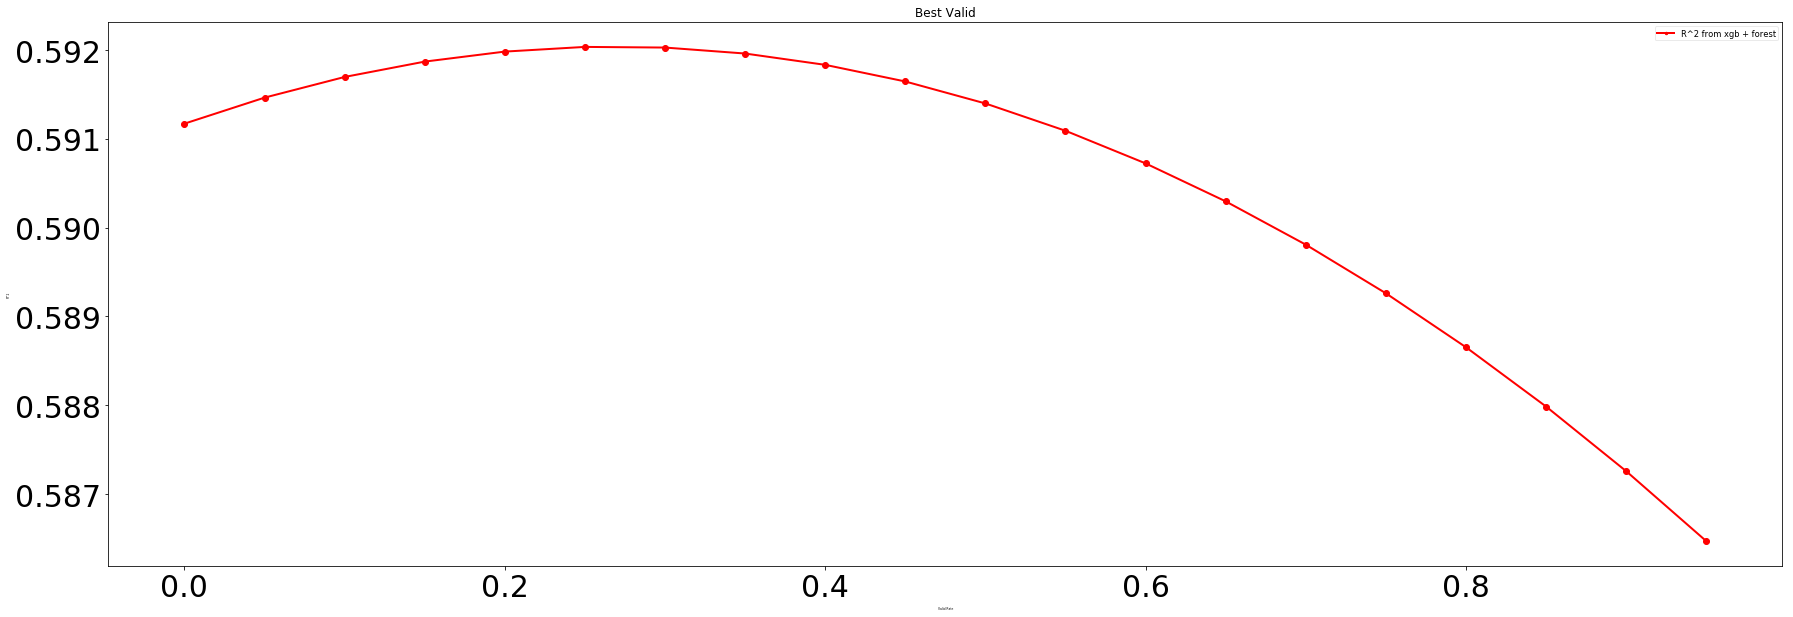

In [72]:
ig = plt.figure(figsize=(30,10))
plt.plot(np.arange(0,1,0.05), pist_valid, 'ro-', linewidth=2)
plt.title('Best Valid')
plt.xlabel('Valid Rate',fontsize=3)
plt.ylabel('R^2',fontsize=3)
plt.tick_params(labelsize=30)
leg = plt.legend(['R^2 from xgb + forest'], loc='best', borderpad=0.3,
                 shadow=False, prop= matplotlib.font_manager.FontProperties(size='small'),
                 markerscale=0.4)
leg.get_frame().set_alpha(0.4)
leg.draggable(state=True)
plt.show()

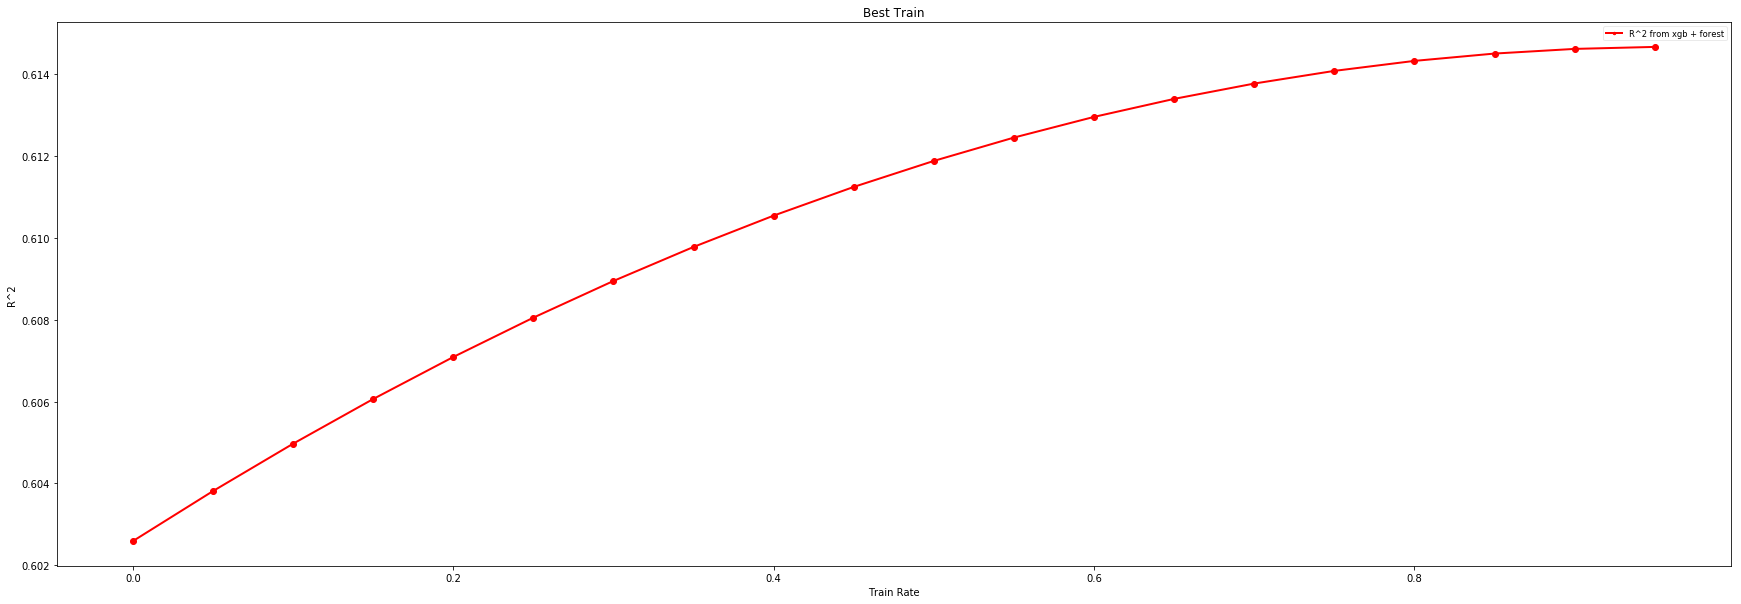

In [73]:
ig = plt.figure(figsize=(30,10))
plt.plot(np.arange(0,1,0.05), pist_train, 'ro-', linewidth=2)
plt.title('Best Train')
plt.xlabel('Train Rate')
plt.ylabel('R^2')
leg = plt.legend(['R^2 from xgb + forest'], loc='best', borderpad=0.3,
                 shadow=False, prop= matplotlib.font_manager.FontProperties(size='small'),
                 markerscale=0.4)
leg.get_frame().set_alpha(0.4)
leg.draggable(state=True)
plt.show()

In [74]:
y_pred_xgb = model.predict(dtest)

In [75]:
y_pred=y_pred_xgb*0.25+ y_pred_forest*0.75

In [76]:
sub = pd.DataFrame()
sub['ID'] = id_test
sub['y'] = y_pred
sub.to_csv('average-xgb25+forest75.csv', index=False)